In [566]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import os

In [567]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train = torch.from_numpy(np.load("/kaggle/input/solvrocompetition/X_train.npy"))
X_test = torch.from_numpy(np.load("/kaggle/input/solvrocompetition/X_test.npy"))
X_val = torch.from_numpy(np.load("/kaggle/input/solvrocompetition/X_val.npy"))

y_train = torch.from_numpy(np.load("/kaggle/input/solvrocompetition/y_train.npy"))
y_val = torch.from_numpy(np.load("/kaggle/input/solvrocompetition/y_val.npy"))

In [568]:
y_train.shape, X_train.shape

(torch.Size([151166, 26]), torch.Size([151166, 28, 28]))

In [569]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([151166, 28, 28]),
 torch.Size([37792, 28, 28]),
 torch.Size([151166, 26]),
 torch.Size([37792, 26]))

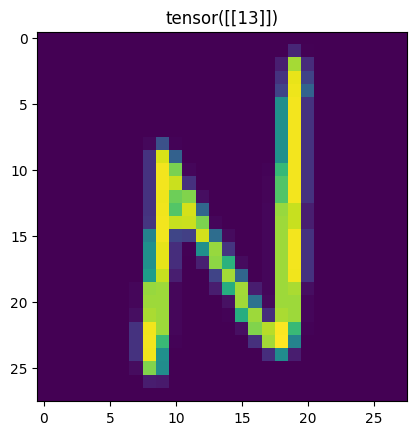

In [570]:
random_index = torch.randint(0, len(X_train), size=[1]).item()
face1 = X_train[random_index].reshape(28,28)
plt.imshow(face1)
plt.title(y_train[random_index].nonzero())
plt.show()

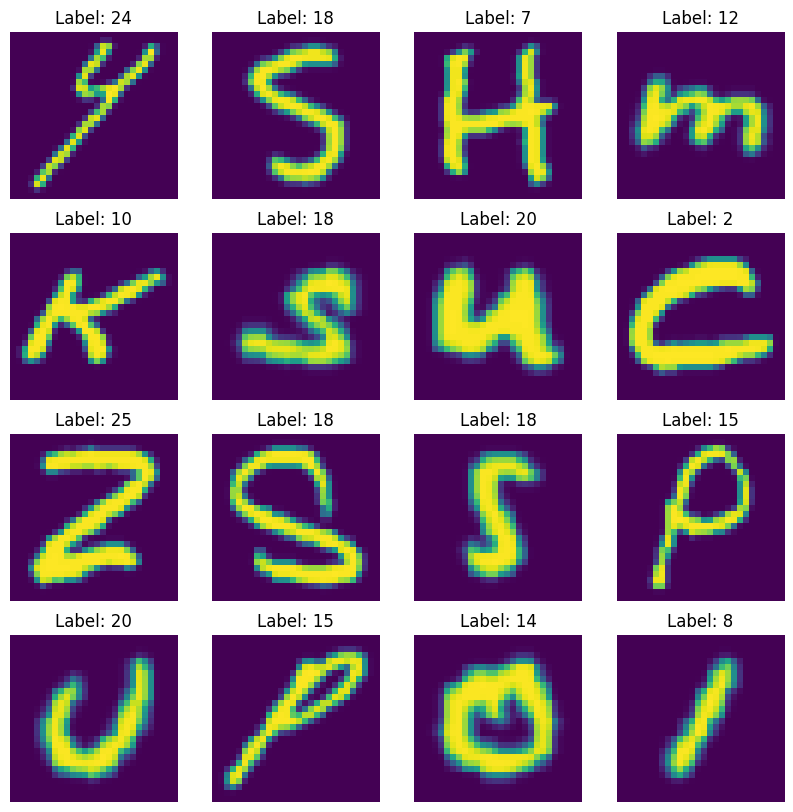

In [571]:
fig = plt.figure(figsize=(10, 10))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_index = torch.randint(0, len(X_val), size=[1]).item()
    face1 = X_val[random_index].reshape(28,28)
    fig.add_subplot(rows, cols, i)
    label = y_val[random_index]
    plt.imshow(face1)
    plt.title("Label: " + str(label.nonzero().item()))
    plt.axis(False);

In [572]:
X_train.unsqueeze(1)[0].shape, X_val[0].shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]))

In [573]:
from torch.utils.data import TensorDataset
# import torchvision
# from torchvision import datasets
# from torchvision.transforms import ToTensor

# train_data = datasets.MNIST(
#     root="data",
#     train=True,
#     download=True,
#     transform=ToTensor(),
#     target_transform=None
# )
# test_data = datasets.MNIST(
#     root="data",
#     train=False,
#     download=True,
#     transform=ToTensor()
# )

image, label
train_dataset = TensorDataset(X_train.unsqueeze(1), y_train)
val_dataset = TensorDataset(X_val.unsqueeze(1), y_val)
# test_dataset = CustomDataset(X_test, y_test)
image, label = train_data[0]

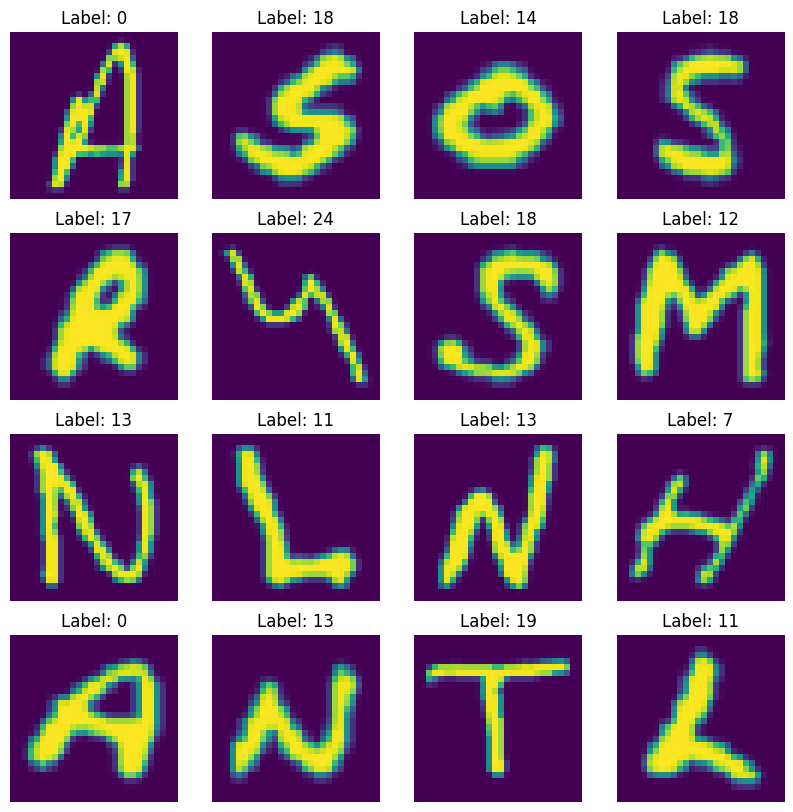

In [574]:
fig = plt.figure(figsize=(10, 10))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_index = torch.randint(0, len(X_train), size=[1]).item()
    face1 = X_train[random_index].reshape(28,28)
    fig.add_subplot(rows, cols, i)
    label = y_train[random_index]
    plt.imshow(face1)
    plt.title("Label: " + str(label.nonzero().item()))
    plt.axis(False);

In [575]:
for i, (data, labels) in enumerate(train_dataset):
    print(f"Sample {i}:")
    print(f"Data shape: {data.shape}")
    print(f"Labels shape: {labels.shape}")
    if i == 3:  # Only print the first 4 samples
        break

Sample 0:
Data shape: torch.Size([1, 28, 28])
Labels shape: torch.Size([26])
Sample 1:
Data shape: torch.Size([1, 28, 28])
Labels shape: torch.Size([26])
Sample 2:
Data shape: torch.Size([1, 28, 28])
Labels shape: torch.Size([26])
Sample 3:
Data shape: torch.Size([1, 28, 28])
Labels shape: torch.Size([26])


In [576]:
# Get the first sample and its label from the dataset
sample, label = train_dataset[0]

# Print the shape of the sample and the label
print("Sample shape:", sample.shape)
print("Label shape:", label.shape)


Sample shape: torch.Size([1, 28, 28])
Label shape: torch.Size([26])


In [577]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"

train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [578]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [579]:
class MNIST_Model(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
      super().__init__()
      self.block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3, # how big is the square that's going over the image?
                    stride=1, # default
                    padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride value is same as kernel_size
      )
      self.block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*7*7,
                    out_features=output_shape)
      )

  def forward(self, x):
    return self.classifier(self.block_2(self.block_1(x)))

model = MNIST_Model(1, 10, len(labels)).to(device)
model

MNIST_Model(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=26, bias=True)
  )
)

In [580]:
# next(iter(test_dataloader)).shape, next(iter(train_dataloader)).shape,X_test.unsqueeze(1).shape

In [581]:
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> [torch.float]:
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

EPOCHS = 4

In [582]:

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device = device):
  train_loss, train_acc = 0, 0
  model.train()
  model.to(device)
  for batch, (X,y) in enumerate(dataloader):
    #print(X.shape)
    X, y= X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)
      )

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [585]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy_fn,
          epochs: int,
          device:torch.device = device):

  from timeit import default_timer as timer
  from tqdm.auto import tqdm
  train_time_start = timer()

  for epoch in tqdm(range(epochs)):
    if epoch % 200:
      print(f"Epochs: {epoch}\n-----------------------")

    train_step(model=model,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)
    test_step(model=model,
              dataloader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

  train_time_end = timer()
  print(f"{(train_time_end - train_time_start):.3f}")

In [586]:
train(model=model,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      accuracy_fn=accuracy_fn,
      epochs=EPOCHS)

  0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.76787 | Train accuracy: 74.98%
Test loss: 0.15313 | Test accuracy: 95.36%

Epochs: 1
-----------------------
Train loss: 0.14853 | Train accuracy: 95.54%
Test loss: 0.11056 | Test accuracy: 96.61%

Epochs: 2
-----------------------
Train loss: 0.10861 | Train accuracy: 96.73%
Test loss: 0.09024 | Test accuracy: 97.00%

Epochs: 3
-----------------------
Train loss: 0.08840 | Train accuracy: 97.30%
Test loss: 0.07083 | Test accuracy: 97.74%

44.971


In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            print(sample.device)

            print(data[0].device)
            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [ ]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({labels[test_labels[0]]})")

In [ ]:
pred_probs= make_predictions(model=model,
                             data=test_samples)

# pred_probs[:2]

In [ ]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

In [ ]:
test_labels, pred_classes

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
print(test_labels)
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = labels[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = labels[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);